In [1]:
import mdtraj as md
import pyemma as pm

import openpathsampling as ops
import openpathsampling.visualize as ops_vis

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sys
from pathlib import Path
import os
import pickle
import pandas 
import numpy as np
from IPython.display import SVG
from tqdm import tqdm

In [2]:
title = 'CLN_tica-cv-2_tps'
model_path = Path(r'./data/CLN_msm/')
storage_path = Path(f'./data/{title}')
results_path = Path(f'./results/{title}')
fig_path = results_path.joinpath('fig')
fig_path.mkdir(parents=True, exist_ok=True)

# import cvs from file
sys.path.append(str(storage_path))
from cvs import *

frame_interval = 1 #ps

In [3]:
# Load storage in read-only way
storage = ops.AnalysisStorage(storage_path.joinpath(f'{title}.nc'))
engine = storage.engines[1] 
scheme = storage.schemes[0]
scheme.move_summary(storage.steps)
print("File size: {0} for {1} steps, {2} snapshots".format(
    storage.file_size_str,
    len(storage.steps),
    len(storage.snapshots)))

  0%|          | 0/10001 [00:00<?, ?it/s]

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 3393/10000 (33.93%)
File size: 417.99GB for 10001 steps, 5736820 snapshots


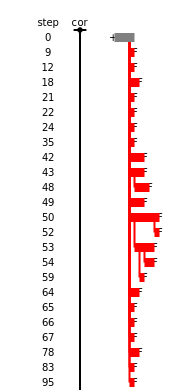

In [4]:
# To visualize the time evolution of samples use pathtree
tree_head = ops_vis.PathTree(
            storage.steps[0:100],
            ops_vis.ReplicaEvolution(replica=0))

tree_full = ops_vis.PathTree(
            storage.steps,
            ops_vis.ReplicaEvolution(replica=0))

SVG(tree_head.svg())

In [5]:
# Count the number of decorrelated trajectories
print(len(tree_full.generator.decorrelated_trajectories))

480


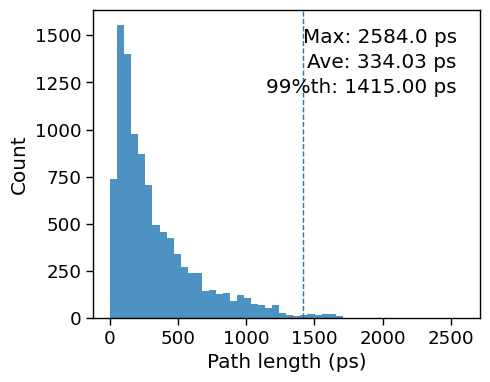

In [6]:
# Path length distribution
# Includes all paths -- paths are kept if its move is rejected 
# Path length distribution gives us an idea of the maximum path length allowed to save computational cost

path_lengths = [len(step.active[0].trajectory) for step in storage.steps]
percentile = np.percentile(path_lengths, 99)

text_0 = f"Max: {max(path_lengths)*engine.snapshot_timestep}"
text_1 = "Ave: " + (np.mean(path_lengths)*engine.snapshot_timestep).format('%.2f')
text_2 = "99%th: " + (percentile*engine.snapshot_timestep).format('%.2f')

with sns.plotting_context('paper', font_scale=1.5):
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    ax.hist(path_lengths, bins=50, alpha=0.8)
    ax.annotate(text=text_0, xy=(0.94,0.94), xycoords='axes fraction', ha='right', va='top')
    ax.annotate(text=text_1, xy=(0.94,0.86), xycoords='axes fraction', ha='right', va='top')
    ax.annotate(text=text_2, xy=(0.94,0.78), xycoords='axes fraction', ha='right', va='top')
    ax.axvline(percentile, ls='--', lw=1)
    
    ax.set_ylabel("Count")
    ax.set_xlabel("Path length (ps)")
    
    plt.savefig(fig_path.joinpath('len_dist.png'), bbox_inches='tight')
    plt.show()

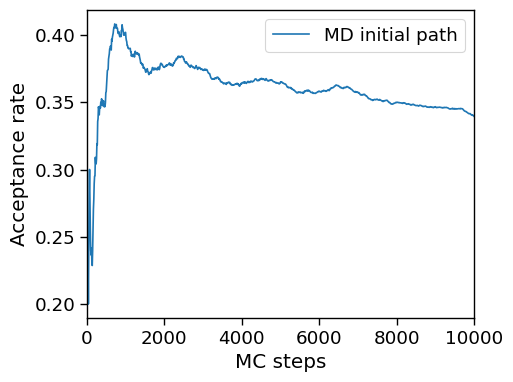

In [7]:
# Plot the smoothed acceptance rate every n=10 MC steps 

move_accepted = [step.change.accepted for step in storage.steps]
n = 10

with sns.plotting_context('paper', font_scale=1.5):
    x = np.arange(n, len(move_accepted)+1, n)
    y = [sum(move_accepted[:i])/i for i in x]
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    ax.plot(x, y, label='MD initial path')
    ax.set_xlabel('MC steps')
    ax.set_ylabel('Acceptance rate')
    ax.set_xlim([0, len(move_accepted)])
    ax.legend()
    
    plt.savefig(fig_path.joinpath('accepted_vs_mcstep.png'), bbox_inches='tight')
    plt.show()

In [8]:
# Transfrom a trajectory onto the predifined tica space

with open(model_path.joinpath('msm_models'), 'rb') as f:
    models = pickle.load(f)
    tica_mod = models['tica_mod']
    kmeans_mod = models['kmeans_mod']
    msm = models['msm']
    
def get_path_tica(traj, tica_mod, f_scheme):
    path_tica = []
    for snapshot in traj:
        path_tica.append(get_tica(snapshot, tica_mod, f_scheme))
    return np.array(path_tica)

In [ ]:
# Get path density
paths = [step.active[0].trajectory for step in storage.steps]
accepted_paths = [step.active[0].trajectory for step in storage.steps if step.change.accepted]

paths_tica = []
for path in tqdm(paths[1:], total=len(paths[1:])):
    paths_tica.append(get_path_tica(path, tica_mod=tica_mod, f_scheme='ca')[:,:2])
d_tica = np.concatenate(paths_tica, axis=0)

margin_x = (np.max(d_tica[:, 0]) - np.min(d_tica[:, 0]))*0.1
margin_y = (np.max(d_tica[:, 1]) - np.min(d_tica[:, 1]))*0.1
xy_range = [[np.min(d_tica[:, 0])-margin_x, np.max(d_tica[:, 0])+margin_x],
            [np.min(d_tica[:, 1])-margin_y, np.max(d_tica[:, 1])+margin_y]]

 33%|█▎  | 3314/10000 [5:21:34<31:20:56, 16.88s/it]

In [10]:
# Concatenate all trajectorys
cat_paths = paths[1].to_mdtraj().remove_solvent(inplace=True)
for path in tqdm(paths[2:10], total=len(paths[2:10])):
    cat_paths = md.join(cat_paths, path.to_mdtraj().remove_solvent(inplace=True))

100%|██████████████████████| 8/8 [00:00<00:00, 34.34it/s]


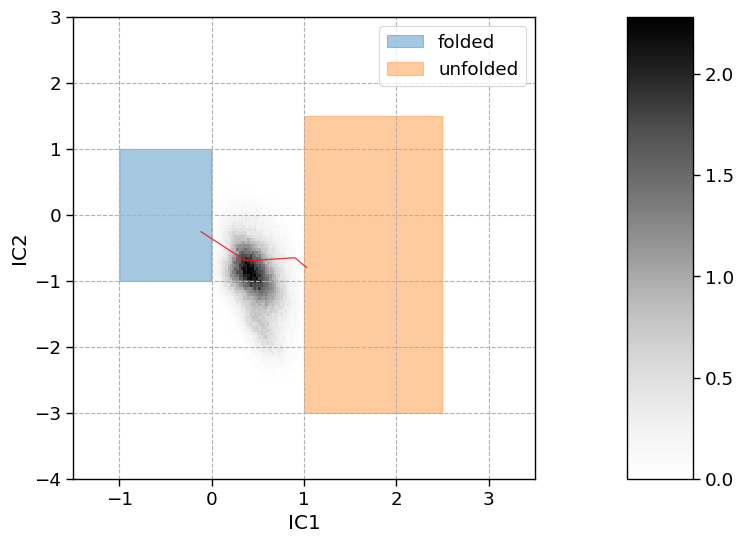

In [77]:
# Path density histogram on TICA space

folded_x = np.arange(-1, 0, 0.001)
folded_y1 = -1
folded_y2 = 1
unfolded_x = np.arange(1,2.5,0.001)
unfolded_y1 = -3
unfolded_y2 = 1.5

show_traj = True
paths_ix = [1]

cmap = mpl.colormaps['Set1'].colors

with sns.plotting_context('paper', font_scale=1.5):
    fig = plt.figure(figsize=(8, 6))
    gs = fig.add_gridspec(nrows=6, ncols=8)
    
    ax1 = fig.add_subplot(gs[:, :6])
    ax2 = fig.add_subplot(gs[:, 7:8])
    
    hist = ax1.hist2d(d_tica[:,0],d_tica[:,1],
                bins=100,
                range=xy_range,
                density=True,
                cmap='Greys')
    cbar = plt.colorbar(hist[3], cax=ax2)
    
    if show_traj == True:
        for i, ix in enumerate(paths_ix):
            path_tica = get_path_tica(accepted_paths[ix], tica_mod=tica_mod, f_scheme='ca')[:,:2]
            ax1.plot(path_tica[:,0], path_tica[:,1], lw=1, c=cmap[i], alpha=0.8)
        
    ax1.fill_between(folded_x, folded_y1, folded_y2, color='C0', alpha=0.4, label='folded')
    ax1.fill_between(unfolded_x, unfolded_y1, unfolded_y2, color='C1', alpha=0.4, label='unfolded')
    
    ax1.grid(axis='both', ls='--')
    ax1.set_xlabel('IC1')
    ax1.set_ylabel('IC2')
    ax1.set_xlim([-1.5,3.5])
    ax1.set_ylim([-4,3])
    ax1.legend()
    plt.savefig(fig_path.joinpath(f'path_density_show_{show_traj}_{paths_ix}.png'), bbox_inches='tight')